<a href="https://colab.research.google.com/github/thunder913/Deep-Learning/blob/main/stocks_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import kagglehub
import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import pickle
import sys
import pdb
import tensorflow as tf
import keras
import random

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, AdditiveAttention, Multiply, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import load_model

# Stock Price Prediction usign LSTM

by Andon Gorchov (@thunderman913)

## Abstract

Stock market prediction is a very challenging task, due to the high volatility and nonlienear financial data. Many people try to "beat" the market, but it is a difficult task, even for the Wall Street traders. In this project, we develop a deep learning model based on Long Short-Term Memory(LSTM), in order to predict stock prices. This type of models should be well-suited for time-series forecasting as they effectively capture long-term dependencies and trends. The model will be trained on historical data with precalculated key technical indicators, as well as feature scaling, attention mechanism and different hyperparameters will be tried. Our goal is to create a model, that predicts the short-term stock price trends. The model will be only technical indicators, so in the future it can be extended with market sentiment analysis, economic factors and financial data.

## 1. Problem Definition

To predict the stock market is a very challenging century old task, that has not yet been perfected. If anyone can foresee the stock prices, he would for sure be very wealthy, since it is a very dynamic enviornment. The goal of the project is to create a good enough LSTM model, that predicts the stock price in the short-term. We will experiment with different hyperparameters and models. The data, that will be used is 24 million rows of stock data. We will feature engineer different technical indicators such as RSI, MACD and moving averages in order to predict the most correct price. I am not expecting the model to predict very accurately to the actual price, due to the volatility of the stock data, but I expect it to manage to follow the trend and give close to real values.

## 2. Data analysis and tidying

We will need a big stock dataset, in order for the model to predict different tickers accurately. We will be using tihs one:

https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

It contains daily stock price information for more than 7000 tickers. For our training purposes we will only use tickers with data, that has at least 100 days of information, which is around 7600 tickers and in total of 24 million rows of data, which are from 1998 to mid 2021 Apart from the given data, there will be some feature engineered variables, that we will look into.

In the project we will be using pickles, in order not to download the dataset every time. Also all the fitted models are going to be stored in pickles.

At first let's define path variables, depending on the running enviornment.

All the fitting of the models will be done on google colab, since it will be very time consuming to use my local machine. All the files will be saved to the google drive, when running on colab and locally, when run locally.

In [42]:
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    base_path = './drive/MyDrive/DL_Pickles_3'
else:
    base_path = 'pickles'

path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

stock_prices_path = f"{path}/stocks_latest/stock_prices_latest.csv"

stock_data_path = f"{base_path}/stock_data_processed.pkl"
scaler_path = f"{base_path}/scalers.pkl"

data_path = f"{base_path}/scaled_stock_data.pkl"  # Path to store scaled DataFrame

sequence_length = 30

numerical_columns = [
    'close_adjusted', '5_day_MA', '10_day_MA',
    '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA'
]

Mounted at /content/drive


Next up let's define some functions for the data processing. At first we will create methods for calculating Relative Strength Index (RSI) and MACD (Moving Average Convergence Divergence). The RSI is a momentum indicator used to measure the speed and change of price movements. Usually below 30 means oversold and above 70 means overbought. MACD is a trend following momentum indicator, that shows the relationship between two moving averages of a stock's price. In our case we will use the most common MACD with short window 12, long window 26 and signal window 9.

In [43]:
def calculate_rsi(ticker_data, period = 14):
    delta = ticker_data['close_adjusted'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / np.where(avg_loss != 0, avg_loss, 1)

    ticker_data['RSI'] = 100 - (100 / (1 + rs))

    return ticker_data

def calculate_macd(ticker_data, short_window=12, long_window=26, signal_window=9):
    # Calculate EMA short and long
    ema_short = ticker_data['close_adjusted'].ewm(span=short_window, adjust=False).mean()
    ema_long = ticker_data['close_adjusted'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    ticker_data['MACD'] = ema_short - ema_long
    ticker_data['Signal_Line'] = ticker_data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return ticker_data

Next up let's define a method for adding the technical indicators to the main dataframe. Apart from calling the above methods, it also calculates moving averages (MA).

Moving averages are a trend following indicator, that smooths out price data to identify the direction of a trend. It helps traders filter out short term price fluctuations and focus on the broader trend.

In [44]:
def process_ticker_data(df):
    """
    Add historical price features for specific days ago for each stock (grouped by ticker).
    Also calculate the peak price and days since the peak price for each stock.
    """

    print('Calculated RSI')
    # Calculate RSI
    df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)

    print('Calculated moving averages')
    # Add moving averages
    moving_average_windows = [5, 10, 20, 50, 100, 200]  # Specify moving average windows

    for window in moving_average_windows:
        df[f'{window}_day_MA'] = (
            df.groupby('ticker')['close_adjusted']
            .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        )

    print('Calculated MACD')
    # Calculate MACD and Signal Line

    df = df.groupby('ticker', group_keys=False).apply(calculate_macd)

    # Remove the first 200 rows for each ticker
    df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)

    return df

Next up let's create a method for scaling the stock data. We will be using a different minmaxscaler for each ticker, because otherwise the data gets really compressed and the models cannot accurately predict it. While some outliers with high/low data are alone by themselves.

In [45]:
def plot_adjusted_close_histogram(stock_data_tidy, column):
    """
    Plots a histogram of the adjusted close prices as a percentage distribution.

    Parameters:
        stock_data_tidy: DataFrame containing column named "column" from the passed variables.
        column: The column name.
    """
    plt.figure(figsize=(10, 5))

    # Compute histogram weights as percentages
    weights = np.ones_like(stock_data_tidy[column]) / len(stock_data_tidy[column]) * 100

    plt.hist(
        stock_data_tidy[column],
        bins=50,
        weights=weights,
        edgecolor='black',
        alpha=0.7
    )

    plt.xlabel(column)
    plt.ylabel('Percentage (%)')
    plt.title(f'Distribution of {column} (Percentage)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [46]:
def scale_stock_data(stock_data_tidy, numerical_columns):
    """
    Scales numerical columns for each stock ticker independently using MinMaxScaler.

    - Loads existing scalers and scaled data if available.
    - Trains and saves new scalers & scaled data if they don’t exist.
    - Returns a new scaled DataFrame without modifying the original.

    Args:
        stock_data_tidy: The input stock data.
        numerical_columns: The numerical column names, that need to be rescaled.

    Returns:
        pd.DataFrame: The scaled stock data.
    """

    if os.path.exists(scaler_path) and os.path.exists(data_path):
        print("Loading existing scalers and scaled data...")

        # Load scalers
        with open(scaler_path, "rb") as f:
            scalers = pickle.load(f)

        # Load scaled stock data
        with open(data_path, "rb") as f:
            new_data_tidy_rescaled = pickle.load(f)

        print("Loaded scalers and scaled data from file.")
        return new_data_tidy_rescaled

    # If files don't exist, compute scalers and scaled data
    print("Recalculating scalers and scaled data...")
    scalers = {}
    new_data_tidy_rescaled = []

    for ticker in stock_data_tidy['ticker_encoded'].unique():
        print(f"Processing ticker: {ticker}")

        ticker_data = stock_data_tidy[stock_data_tidy['ticker_encoded'] == ticker].copy()

        scaler = MinMaxScaler()
        scalers[ticker] = scaler.fit(ticker_data[numerical_columns])

        scaler_macd = MinMaxScaler(feature_range=(-1,1))
        scaler_rsi = MinMaxScaler()

        ticker_data[['MACD', 'Signal_Line']] = scaler_macd.fit_transform(ticker_data[['MACD', 'Signal_Line']])
        ticker_data['RSI'] = scaler_rsi.fit_transform(ticker_data[['RSI']])
        ticker_data.loc[:, numerical_columns] = scaler.transform(ticker_data[numerical_columns])

        new_data_tidy_rescaled.append(ticker_data)

    new_data_tidy_rescaled = pd.concat(new_data_tidy_rescaled, ignore_index=True)

    with open(scaler_path, "wb") as f:
        pickle.dump(scalers, f)

    with open(data_path, "wb") as f:
        pickle.dump(new_data_tidy_rescaled, f)

    print("Saved scalers and scaled data to file.")

    return new_data_tidy_rescaled

Finally let's create the method for getting the tidied data. It contains all the technical indicators, scaled prices and tickers.

In [47]:
def getTidiedStockData():
    """
    Read and tidy the stock data dataset. If the processed stock data already exists as a pickle file,
    it loads and returns the data. Otherwise, it processes the raw stock data, cleans it, adds features,
    and saves the tidy data to a pickle file for future use.
    """

    # Check if the file exists
    if os.path.exists(stock_data_path):
        print('found pickle')
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)
    stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close', 'volume'])

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

    stock_data_tidy['day_of_week'] = stock_data_tidy['date'].dt.dayofweek

    stock_data_tidy = scale_stock_data(stock_data_tidy, numerical_columns)

    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [48]:
stock_data_tidy = getTidiedStockData()

with open(scaler_path, "rb") as f:
    scalers = pickle.load(f)

numerical_columns.extend(['RSI', 'MACD', 'Signal_Line'])

found pickle


After loading the data, let's see what kind of data we have finally calculated.

In [49]:
stock_data_tidy

,ticker,date,close_adjusted,RSI,5_day_MA,10_day_MA,20_day_MA,50_day_MA,100_day_MA,200_day_MA,MACD,Signal_Line,ticker_encoded,day_of_week
0,A,2000-09-05,0.264907,0.861415,0.267190,0.263481,0.221243,0.243935,0.305796,0.376189,0.608022,0.374957,0,1
1,A,2000-09-06,0.255498,0.802317,0.264028,0.263213,0.226976,0.242257,0.304060,0.376823,0.593381,0.428158,0,2
2,A,2000-09-07,0.265271,0.793422,0.264555,0.263952,0.233082,0.240753,0.302856,0.377403,0.601826,0.472622,0,3
3,A,2000-09-08,0.251599,0.574629,0.262711,0.263684,0.238560,0.238506,0.301684,0.378017,0.568268,0.500635,0,4
4,A,2000-09-11,0.238604,0.393577,0.257305,0.262748,0.242921,0.236384,0.299933,0.378527,0.503918,0.508551,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22842278,ZYXI,2021-06-07,0.550810,0.732705,0.582282,0.581736,0.582730,0.668157,0.818492,0.879116,-0.021146,-0.120172,7643,0
22842279,ZYXI,2021-06-08,0.563063,0.716218,0.585422,0.587154,0.586742,0.669251,0.819131,0.878953,0.010483,-0.089874,7643,1
22842280,ZYXI,2021-06-09,0.562363,0.741475,0.591402,0.594646,0.590815,0.670381,0.818896,0.878901,0.032761,-0.060701,7643,2
22842281,ZYXI,2021-06-10,0.561663,0.700733,0.594542,0.600448,0.595007,0.671556,0.818661,0.879093,0.047460,-0.034107,7643,3


So we have the ticker and ticker_encoded. We will pass the ticker as ticker_encoded to the model. We also have the date of the row and based on the date we have day_of_week feature, which is very useful, since some days have higher market volatility than others. And the last column from the dataset is close_adjusted, which is the final close price of the day.

Next up we have feature engineered the other columns:

- RSI (Relative strength index)
- Moving averages - we will ahve 5, 10, 20, 50, 100 and 200 day moving averages
- MACD and Sginal Line

All of the data has been minmaxscaled to accomodate the model.
We have one minmaxscaler for the price columns - close_adjusted and moving averages.
The MACD and signal line are with a separate scaler, as well as the RSI.

They are done with separate scalers, because if we scaled all the features together, the model might misinterpret their relative importance, since technical indicator values are generally in the range 0 to 1 and scaling them with prices of up to 10 000, would make them very small and harder to find patterns.

Now let's see some distributions, on what we are going to fit the model.

Let's begin with close price

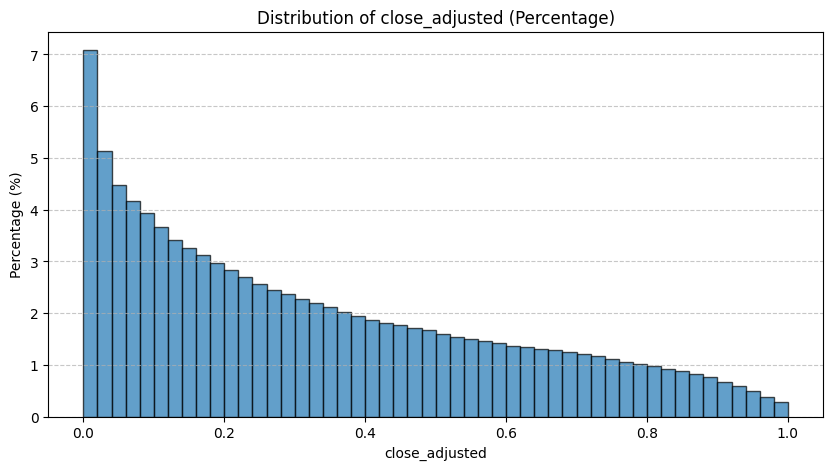

In [50]:
plot_adjusted_close_histogram(stock_data_tidy, 'close_adjusted')

We can observe, that the data is right-skewed, meaning most of the prices are concentrated near 0. This is normal, because we are using data from 1998 to 2021 and in the early years, there we so little companies worth a lot of money. The LSTM model is generally fine with this distribution, because mainly focus on capturing temporal dependencies and not necesserily on exact distributions. We would expect the model to be a little bit more biased on the lower values, that the higher ones.

Let's see some distributions of the technical indicators.

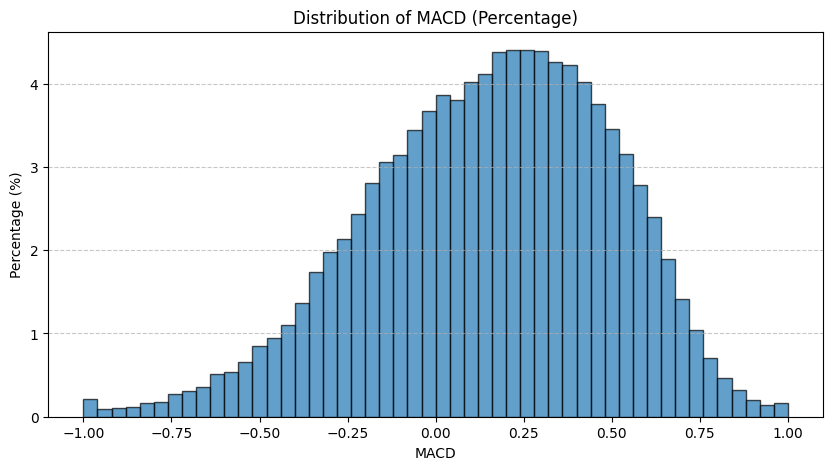

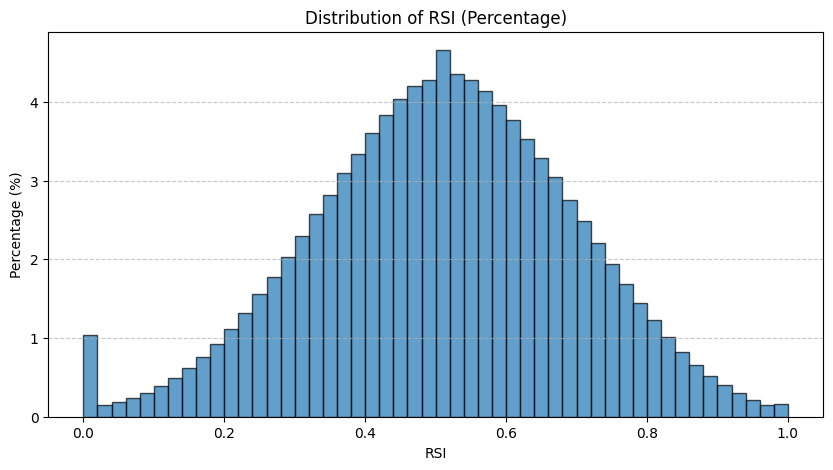

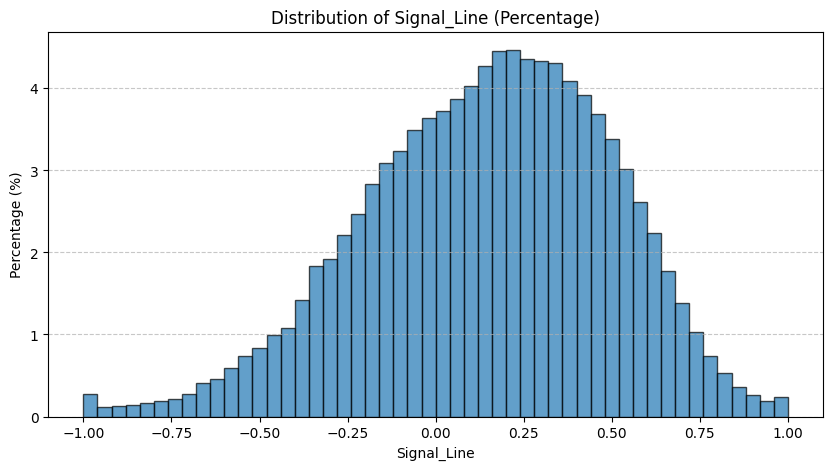

In [51]:
plot_adjusted_close_histogram(stock_data_tidy, 'MACD')
plot_adjusted_close_histogram(stock_data_tidy, 'RSI')
plot_adjusted_close_histogram(stock_data_tidy, 'Signal_Line')


We can see, that all the features are properly scaled and they have very simillar distributions, peaking in the middle, which is normal for those indicators. It means the price would not change. We also have some peaks at the lowest values and smaller peaks at the highest ones, which indicate sudden and unexpected price movements.

And finally lets see the moving averages.

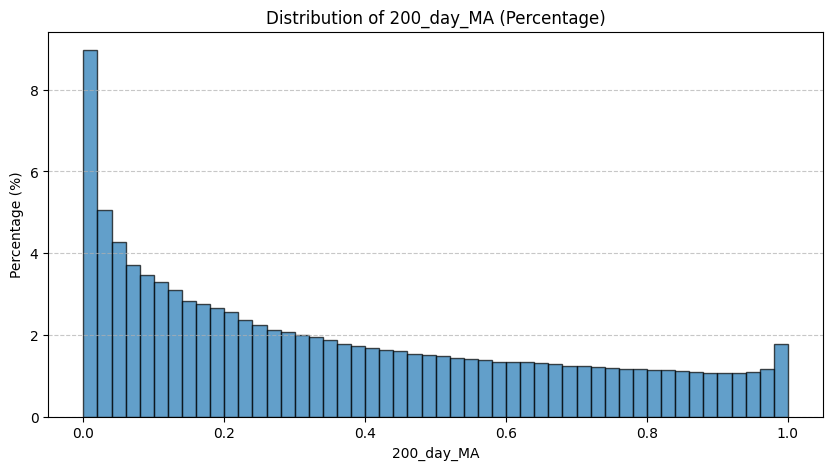

In [52]:
plot_adjusted_close_histogram(stock_data_tidy, '200_day_MA')

As expected they are also right skewed, but also with a small peak near the highest end.

Let's also see, how the moving averages and stock prices look like.

In [53]:
def plot_stock_chart(stock_data_tidy, ticker, start_date, end_date):
    """
    Plots the stock chart with adjusted close prices and moving averages.

    Parameters:
        stock_data_tidy (pd.DataFrame): DataFrame containing stock data.
        ticker (str): Stock ticker symbol.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
    """
    # Filter data for the specified ticker and date range
    filtered_data = stock_data_tidy[(stock_data_tidy['ticker'] == ticker) &
                                    (stock_data_tidy['date'] >= start_date) &
                                    (stock_data_tidy['date'] <= end_date)]

    plt.figure(figsize=(14, 7))
    plt.plot(filtered_data['date'], filtered_data['close_adjusted'], label='Close Adjusted', linewidth=1.5)
    plt.plot(filtered_data['date'], filtered_data['5_day_MA'], label='5-Day MA', linestyle='--')
    plt.plot(filtered_data['date'], filtered_data['50_day_MA'], label='50-Day MA', linestyle='--')
    plt.plot(filtered_data['date'], filtered_data['200_day_MA'], label='200-Day MA', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Stock Chart for {ticker} ({start_date} to {end_date})')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

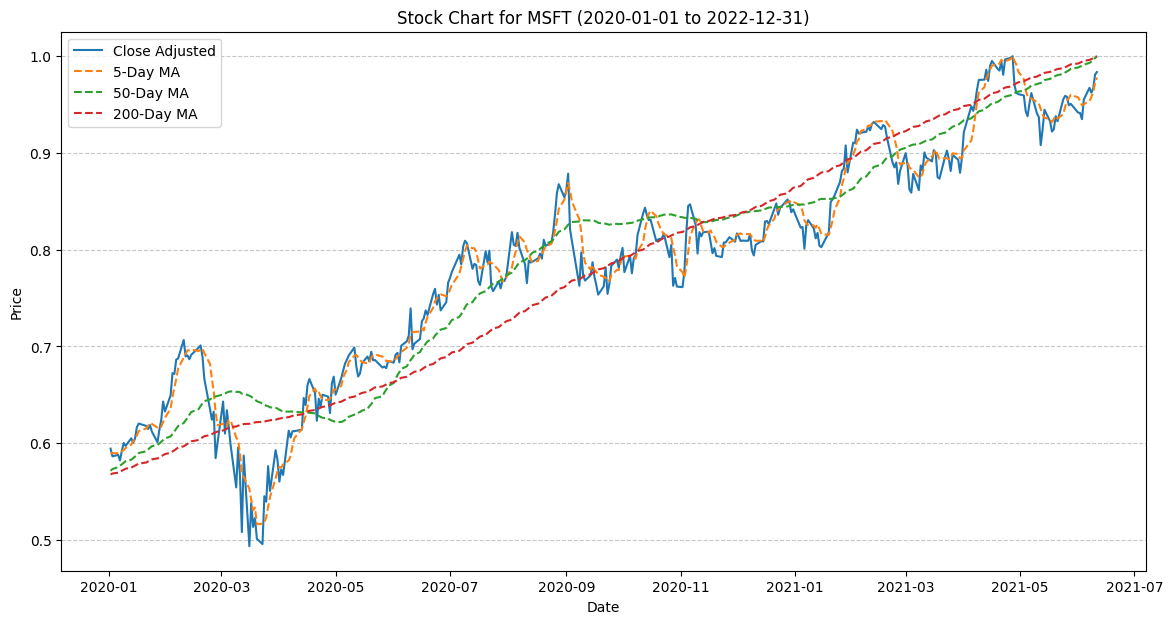

In [54]:
plot_stock_chart(stock_data_tidy, ticker='MSFT', start_date='2020-01-01', end_date='2022-12-31')

Well they seem about right.

## 3. Model Training

During the training we will go through many model generations, most of which will be a complete failure. In this section we will look into the final model training setup. Most of the stuff wasn't used in the early models. In the beginning some of the data wasn't even correct, so that is a reason for not gettin correct predictions obviously. All of the models will be using LSTM, Attention and Dense layers. In the beggining the models didn't even have an attention layer. Maybe let's give some information on what the layers really do.

- LSTM

LSTM are a type of recurrent neural networks designed to handle sequential data and long-term dependencies. They use gates to control the information flow and either keep long term memory or forget the input. They also capture historical movements.

- BatchNormalization

This layer normalizes activations between layers, improving training stability. It helps prevent exploding gradients and reduces the sensitivity of the network to weigh initialization.

- Attention

Attention mechanisms allow the model to focus on the most relevant time steps in the inptu sequence and instead of treating all historical data points equally, it assigns different importance weights to each past observation. It generally helps the model prioritize recent trends over older less relevant data.

- Multiply

It performs element-wise multiplicaiton of tensors. It is used in combination with attention layer to scale input values based on computed attention scores.

- Flatten

It converts a multi-dimensional tensor into a one-dimensional vector. It is placed as transition from LSTM/Attention outputs to a fully connected layer for prediction like the Dense layer.

- Dense

It is a fully connected layer used for final predicitons, where each neuron receives input from all previous layer neurons. The last layer has one neuron, representing the predicted price.

Below we can see the usual model we will be training on, with different units.

In [55]:
def create_lstm_model(sequence_length, num_features, lstm_units_1=50, lstm_units_2=50, dropout_rate=0.1):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    normalized_1 = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(normalized_1)
    normalized_2 = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([normalized_2, normalized_2])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    x = Dense(64, activation='relu', name="dense_1")(flat)

    output = Dense(32, activation='relu', name="dense_2")(x)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [56]:
sample_model = create_lstm_model(sequence_length=sequence_length, num_features=len(numerical_columns))

In [57]:
sample_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_input           │ (None, 30, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_1 (LSTM)       │ (None, 30, 50)         │         12,200 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 30, 50)         │            200 │ lstm_layer_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_2 (LSTM)       │ (None, 30, 50)         │         20,200 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 50)         │            200 │ lstm_layer_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 30, 50)         │             50 │ batch_normalization_3… │
│ (AdditiveAttention)       │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 30, 50)         │              0 │ lstm_layer_2[0][0],    │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1500)           │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         96,064 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 131,027 (511.82 KB)

 Trainable params: 130,827 (511.04 KB)

 Non-trainable params: 200 (800.00 B)

We can see, that we will usually have 2 LSTM layers with BatchNormalization after each one, followed by Attention, Multiply and Flatten layers and finally Dense layers to get the output.

## 3.1. Preparation for training

Let's create some useful methods for the training and afterwards for the model evaluation.

First we are using different scalers for each ticker, let's create a model for easily inversing the predicted data, based on the ticker.

In [58]:
def inverse_transform_predictions(y_pred, ticker):
    # Use the correct scaler for this ticker
    scaler = scalers[ticker]

    # Inverse transform only the first column (close_adjusted)
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate((np.array(y_pred).reshape(-1,1), np.zeros((len(y_pred), len(numerical_columns) - 4))), axis=1)
    )[:,0]

    return y_pred_rescaled

Next up we will need a method for preprocessing the group data. Since the dataset is massive, it is impossible to keep it all in the memory. We will be using generators to load it from files during the training. For that we will need all the data to be preprocessed and ready.

In [59]:
import os
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

processed_data_path = base_path + '/processed_data_full_2_1/'

def preprocess_grouped_data(stock_data_tidy, numerical_columns, target_column, sequence_length):
    tickers = stock_data_tidy["ticker_encoded"].unique()
    batch_size = 200
    batch_x, batch_y = [], []
    batch_count = 1

    for i, ticker in enumerate(tickers, start=1):
        ticker_data = stock_data_tidy[stock_data_tidy["ticker_encoded"] == ticker].sort_values(by="date")
        numerical_data = ticker_data[numerical_columns].values

        if ticker % 1000 == 0:
            print('Processing ', ticker)

        if len(ticker_data) > sequence_length:
            x_ticker = sliding_window_view(numerical_data[:-1], window_shape=(sequence_length, len(numerical_columns)))
            x_ticker = x_ticker.reshape(-1, sequence_length, len(numerical_columns))
            y_ticker = ticker_data[target_column].values[sequence_length:]

            batch_x.append(x_ticker)
            batch_y.append(y_ticker)

        # Save when we reach 200 tickers
        if len(batch_x) == batch_size or i == len(tickers):
            x_combined = np.concatenate(batch_x, axis=0)
            y_combined = np.concatenate(batch_y, axis=0)

            np.save(os.path.join(processed_data_path, f"x_ticker_batch_{batch_count}.npy"), x_combined)
            np.save(os.path.join(processed_data_path, f"y_ticker_batch_{batch_count}.npy"), y_combined)

            print(f"Saved batch {batch_count}: {x_combined.shape}, {y_combined.shape}")

            # Reset batch storage
            batch_x, batch_y = [], []
            batch_count += 1

    print("Batch processing complete.")

When the data is processed in the given files, we will be using a generator, in order for it to be loaded.

In [60]:
stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'])

if os.path.exists(processed_data_path) and os.path.isdir(processed_data_path):
    has_file = any(os.path.isfile(os.path.join(processed_data_path, item)) for item in os.listdir(processed_data_path))
    if has_file:
        print("There are files in the processed_data_path.")
    else:
      print('Beginning to process the data...\n')
      preprocess_grouped_data(stock_data_tidy, numerical_columns, 'close_adjusted', sequence_length)
else:
    print("The processed_data_path does not exist or is not a directory.")

There are files in the processed_data_path.


## 3.2. Generator

Next up let's create a data_generator method, that will be used to loading the data during the fitting process.

In [61]:
import os
import numpy as np
import random

def data_generator(batch_numbers, processed_data_path, batch_size=32):
    """Generates batches dynamically from pre-selected batch numbers."""

    while True:
        random.shuffle(batch_numbers)  # Shuffle batch order

        for batch_num in batch_numbers:
            x_path = os.path.join(processed_data_path, f"x_ticker_batch_{batch_num}.npy")
            y_path = os.path.join(processed_data_path, f"y_ticker_batch_{batch_num}.npy")

            if not os.path.exists(x_path) or not os.path.exists(y_path):
                continue  # Skip missing files

            x_data = np.load(x_path)
            y_data = np.load(y_path)

            # Ensure full batches
            steps_per_epoch = len(x_data) // batch_size
            x_data = x_data[:steps_per_epoch * batch_size]
            y_data = y_data[:steps_per_epoch * batch_size]

            # Shuffle within the batch
            indices = np.arange(len(x_data))
            np.random.shuffle(indices)
            x_data = x_data[indices]
            y_data = y_data[indices]

            # Yield mini-batches
            for i in range(steps_per_epoch):
                x_batch = x_data[i * batch_size: (i + 1) * batch_size]
                y_batch = y_data[i * batch_size: (i + 1) * batch_size]

                yield np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)


As we can see we have an infinite while true loop, that ensures the generator wiull go on forever, until the fitting is done or interrupted.

We always shuffle the tickers, ensuring the randomness of the tickers, since we don't want the model training with the same order. Next up, we skip any files, that do not exist or are empty and finally we get the batches and yield the data.

In [62]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

batch_files = sorted([f for f in os.listdir(processed_data_path) if f.startswith("x_ticker_batch_") and f.endswith(".npy")])
batch_numbers = [int(f.split("_")[-1].split(".")[0]) for f in batch_files]

train_batches, test_batches = train_test_split(batch_numbers, test_size=0.05, random_state=42)

print(f"Train batches: {len(train_batches)}")
print(f"Test batches: {len(test_batches)}")


Train batches: 36
Test batches: 2


The above code splits the data into test and train set. We use 5% of the data for testing, since that is sufficent. It is about 350 tickers and the rest shall be used for training.

In [63]:
train_gen = data_generator(train_batches, processed_data_path, batch_size=32)
test_gen = data_generator(test_batches, processed_data_path, batch_size=32)

early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

Finally we create the data generator and also an early stopping mechanism, if the model doesn't improve anymore. We have set it to patience = 10, which means if in 10 epochs, the models doesn't improve, the training will stop.

## 3.3. Predictions visualization

Next up we will need some methods for actually visualizing the prediction and see with our own eyes, how good or bad the model is.

We should have two line in a plot, that visualize the expected vs actual prices. We expect them to be close to each other.

In [64]:
def get_sequences_and_predict(ticker, stock_data, numerical_columns, sequence_length, model):
    """
    Extracts sequences for a given ticker, performs predictions, and returns rescaled values.

    Parameters:
    - ticker: Stock ticker symbol.
    - stock_data: DataFrame containing stock data.
    - numerical_columns: List of numerical feature columns.
    - sequence_length: Length of sequences.
    - model: Trained model for prediction.

    Returns:
    - dates: Pandas Series of date values.
    - y_sequence_rescaled: Rescaled actual stock prices.
    - y_pred_rescaled: Rescaled predicted stock prices.
    """
    ticker_data = stock_data[stock_data.ticker == ticker]

    X = ticker_data[numerical_columns].values
    y = ticker_data['close_adjusted'].values

    X_sequences = []
    y_sequences = []

    for i in range(sequence_length, len(X)):
        X_sequences.append(X[i-sequence_length:i])
        y_sequences.append(y[i])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    y_pred = model.predict(X_sequences)
    print('predicted')

    y_sequence_rescaled = inverse_transform_predictions(y_sequences, ticker_data.ticker_encoded.unique()[0])
    y_pred_rescaled = inverse_transform_predictions(y_pred, ticker_data.ticker_encoded.unique()[0])

    dates = ticker_data['date'].iloc[sequence_length:].reset_index(drop=True)

    return dates, y_sequence_rescaled, y_pred_rescaled

In [65]:
def plot_actual_vs_predicted(dates, y_actual, y_pred, title='Actual vs Predicted Prices'):
    """
    Plots actual vs predicted stock prices.

    Parameters:
    - dates: Pandas Series or list of date values.
    - y_actual: Actual stock prices.
    - y_pred: Predicted stock prices.
    - title: Title of the plot (default: 'Actual vs Predicted Prices').
    """
    plt.figure(figsize=(12, 6))

    plt.plot(dates, y_actual, label='Actual Prices', alpha=0.8)
    plt.plot(dates, y_pred, label='Predicted Prices', alpha=0.8)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)

    plt.show()


In [66]:
def evaluate_model_on_ticker(ticker, model):
    """
    Calls get_sequences_and_predict() to generate sequences and predictions for a given ticker,
    then calls plot_actual_vs_predicted() to visualize the results.

    Parameters:
    - ticker: Stock ticker symbol (e.g., "TSLA").
    - model: Trained deep learning model.
    """
    dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict(
        ticker, stock_data_tidy, numerical_columns, sequence_length, model
    )

    plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)


## 4. Models

We will go from generation to generation and see what the model's state was and what was tried to imrpove it. Also we will go through all the difficulties.

Let's investigate all the different models tried and see what their outcomes were.

First one - one lstm layer, one dense with only one unit

Second gen - two lstms 64 and 32, with dense 32 and dense 1. Here also scaled data stuff

Third gen - attention layer

fourth - complicated one, huber,

next one fifth - correct RSI and scaled data. think of how complex shall the model be?

TODO load some of the models and do .predict to see how bad they are. Show some images :)

## 4.1. First generation

Missing attention

In [ ]:
first_model = load_model('./pickles/first_gen_model.keras')

C:\Users\andon\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
first_model.summary()

Model: "Optimized_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)    │ (None, 30, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 30, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,141 (1.42 MB)

 Trainable params: 123,713 (483.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 247,428 (966.52 KB)

In [ ]:
evaluate_model_on_ticker("AAPL", first_model)

ValueError: Input 0 of layer "Optimized_LSTM_Model" is incompatible with the layer: expected shape=(None, 30, 11), found shape=(32, 30, 10)

In [ ]:
def create_lstm_model(sequence_length, num_features, lstm_units_1=50, lstm_units_2=50, dropout_rate=0.1):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    normalized_1 = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(normalized_1)
    normalized_2 = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([normalized_2, normalized_2])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    x = Dense(64, activation='relu', name="dense_1")(flat)

    output = Dense(32, activation='relu', name="dense_2")(x)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [ ]:
lstm_model = create_lstm_model(sequence_length=sequence_length, num_features=len(numerical_columns))

In [ ]:
lstm_model.summary()

NameError: name 'lstm_model' is not defined

In [ ]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=base_path + 'lstm_model_epoch_{epoch:02d}.keras',  # Saves model for each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model (architecture + weights)
    verbose=1
)

# Train the model with checkpoint callback
# lstm_model.fit(
#     train_gen,
#     steps_per_epoch=40000,
#     epochs=200,
#     callbacks=[checkpoint, early_stopping],  # Include checkpoint callback
#     verbose=2
# )

print("Training complete!")


Training complete!


## 4.2. Second generation

Seems like a good model, but not trained correctly I believe

In [ ]:
second_model = load_model('./pickles/second_gen_model.keras')

In [ ]:
second_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 50)    │     12,200 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 50)    │        200 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 50)    │     20,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 50)    │        200 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 50)    │         50 │ batch_normalizat… │
│ (AdditiveAttention) │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 30, 50)    │          0 │ lstm_layer_2[0][… │
│                     │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1500)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     96,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 392,683 (1.50 MB)

 Trainable params: 130,827 (511.04 KB)

 Non-trainable params: 200 (800.00 B)

 Optimizer params: 261,656 (1022.10 KB)

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
predicted


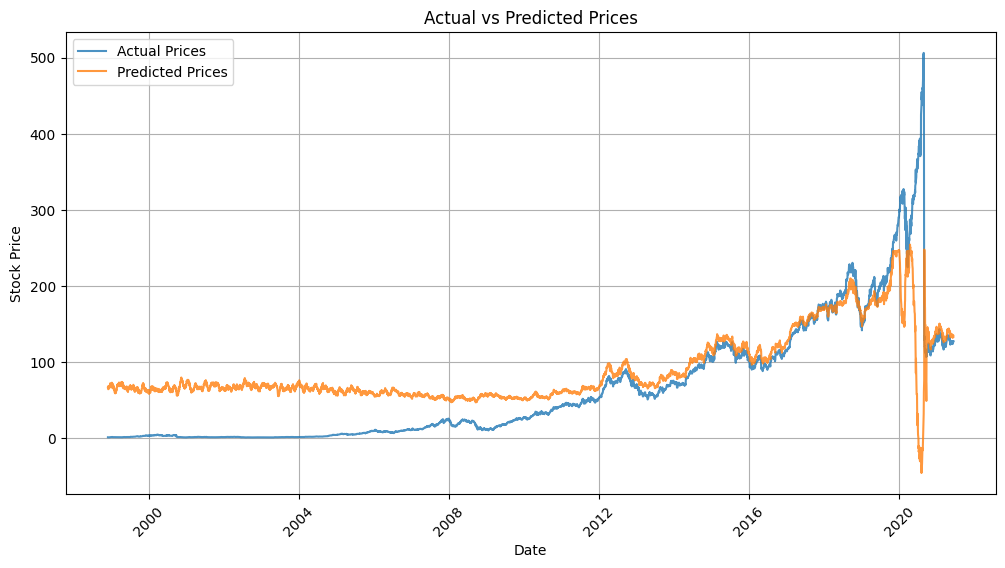

In [ ]:
evaluate_model_on_ticker("AAPL", second_model)

In [ ]:
def create_simpler_lstm_model(sequence_length, num_features, lstm_units_1=256, lstm_units_2=128, lstm_units_3=64, dropout_rate=0.3):
    """
    Optimized LSTM model for stock price prediction with Additive Attention.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    first_lstm_layer = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    normalized_1 = BatchNormalization()(first_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(normalized_1)
    normalized_2 = BatchNormalization()(second_lstm_layer)

    second_lstm_layer = LSTM(lstm_units_3, return_sequences=True, name="lstm_layer_3", dropout=dropout_rate)(normalized_2)
    normalized_3 = BatchNormalization()(second_lstm_layer)

    # Attention mechanism
    attention = AdditiveAttention(name="attention_layer")([normalized_3, normalized_3])
    attended = Multiply()([second_lstm_layer, attention])

    flat = Flatten()(attended)

    output = Dense(32, activation='relu', name="dense_2")(flat)

    output = Dense(1, activation='linear', name="output")(output)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model_with_Attention")
    model.compile(optimizer='adam', loss=Huber(delta=1.0), metrics=['mae'])

    return model

In [ ]:
simple_lstm_model = create_simpler_lstm_model(
    sequence_length=sequence_length,
    num_features=len(numerical_columns))

In [ ]:
simple_lstm_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_input           │ (None, 30, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_1 (LSTM)       │ (None, 30, 256)        │        273,408 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 30, 256)        │          1,024 │ lstm_layer_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_2 (LSTM)       │ (None, 30, 128)        │        197,120 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 30, 128)        │            512 │ lstm_layer_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer_3 (LSTM)       │ (None, 30, 64)         │         49,408 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 30, 64)         │            256 │ lstm_layer_3[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, 30, 64)         │             64 │ batch_normalization_2… │
│ (AdditiveAttention)       │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 30, 64)         │              0 │ lstm_layer_3[0][0],    │
│                           │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1920)           │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │         61,472 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 583,297 (2.23 MB)

 Trainable params: 582,401 (2.22 MB)

 Non-trainable params: 896 (3.50 KB)

## 4.3. Third generation

Was trained on wrong data, but good model

In [ ]:
third_model = load_model('./pickles/third_gen_model.keras')

In [ ]:
third_model.summary()

Model: "Optimized_LSTM_Model_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 30, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_1 (LSTM) │ (None, 30, 256)   │    275,456 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 256)   │      1,024 │ lstm_layer_1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_2 (LSTM) │ (None, 30, 128)   │    197,120 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ lstm_layer_2[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer_3 (LSTM) │ (None, 30, 64)    │     49,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ lstm_layer_3[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 64)    │         64 │ batch_normalizat… │
│ (AdditiveAttention) │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 30, 64)    │          0 │ lstm_layer_3[0][… │
│ (Multiply)          │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1920)      │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │     61,472 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,754,245 (6.69 MB)

 Trainable params: 584,449 (2.23 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1,168,900 (4.46 MB)

In [ ]:
evaluate_model_on_ticker("AAPL", third_model)

ValueError: Input 0 of layer "Optimized_LSTM_Model_with_Attention" is incompatible with the layer: expected shape=(None, 30, 12), found shape=(32, 30, 10)

## 4.4. Fourth model

Complex and correct data.

In [78]:
fourth_model = load_model('./drive/MyDrive/DL_Pickles_3/fourth_gen_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [85]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=base_path + 'simple_fourth_model_epoch_1_{epoch:02d}.keras',  # Saves model for each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model (architecture + weights)
    verbose=1
)

early_stopping = EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)

# Train the model with checkpoint callback
fourth_model.fit(
    train_gen,
    steps_per_epoch=200000//5,
    validation_data=test_gen,
    validation_steps=10000//5,
    epochs=100,
    callbacks=[checkpoint, early_stopping],  # Include checkpoint callback
    verbose=1
)

print("Training complete!")


Epoch 1/100
39997/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2565e-04 - mae: 0.0239
Epoch 1: saving model to ./drive/MyDrive/DL_Pickles_3simple_fourth_model_epoch_1_01.keras
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 488s 12ms/step - loss: 7.2563e-04 - mae: 0.0239 - val_loss: 6.0328e-04 - val_mae: 0.0191
Epoch 2/100
39999/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2632e-04 - mae: 0.0180
Epoch 2: saving model to ./drive/MyDrive/DL_Pickles_3simple_fourth_model_epoch_1_02.keras
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 484s 12ms/step - loss: 4.2632e-04 - mae: 0.0180 - val_loss: 5.6794e-04 - val_mae: 0.0180
Epoch 3/100
39997/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6622e-04 - mae: 0.0168
Epoch 3: saving model to ./drive/MyDrive/DL_Pickles_3simple_fourth_model_epoch_1_03.keras
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 489s 12ms/step - loss: 3.6622e-04 - mae: 0.0168 - val_loss: 5.2538e-04 - val_mae: 0.0186
Epoch 4/100
39998/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3369e-04 - mae: 0.0174


KeyboardInterrupt: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
predicted


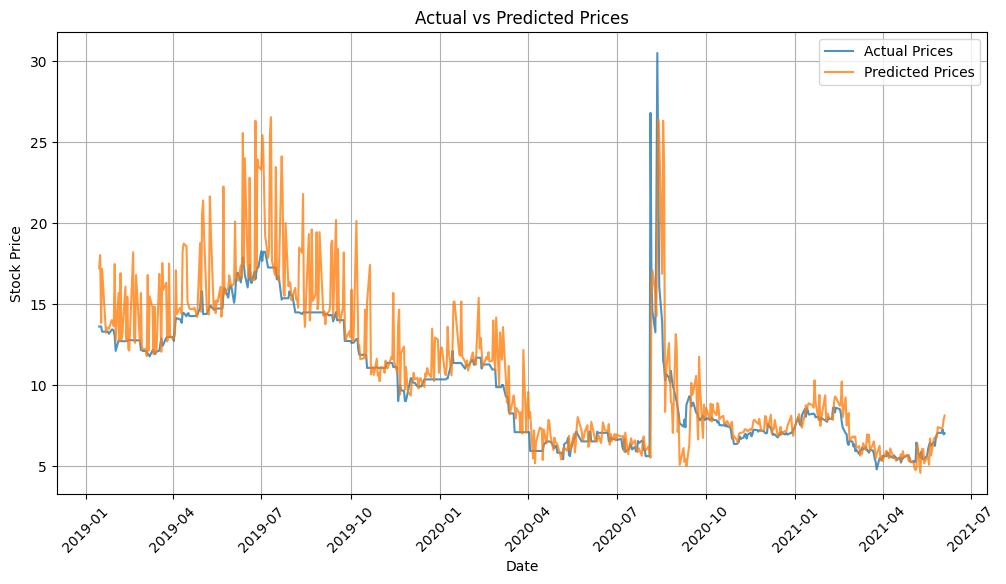

In [89]:
evaluate_model_on_ticker("BFRA", fourth_model)

In [40]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=base_path + 'simple_lstm_model_epoch_6_3_{epoch:02d}.keras',  # Saves model for each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model (architecture + weights)
    verbose=1
)

early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

# Train the model with checkpoint callback
fifth_model.fit(
    train_gen,
    steps_per_epoch=200000//5,
    validation_data=test_gen,
    validation_steps=10000//5,
    epochs=50,
    callbacks=[checkpoint, early_stopping],  # Include checkpoint callback
    verbose=1
)

print("Training complete!")


Epoch 1/50
39996/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8446e-04 - mae: 0.0189
Epoch 1: saving model to ./drive/MyDrive/DL_Pickles_3simple_lstm_model_epoch_6_3_01.keras
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 480s 12ms/step - loss: 5.8444e-04 - mae: 0.0189 - val_loss: 3.3329e-04 - val_mae: 0.0134
Epoch 2/50
39996/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6223e-04 - mae: 0.0126
Epoch 2: saving model to ./drive/MyDrive/DL_Pickles_3simple_lstm_model_epoch_6_3_02.keras
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 441s 11ms/step - loss: 2.6223e-04 - mae: 0.0126 - val_loss: 3.4168e-04 - val_mae: 0.0141
Epoch 3/50
39996/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3703e-04 - mae: 0.0121
Epoch 3: saving model to ./drive/MyDrive/DL_Pickles_3simple_lstm_model_epoch_6_3_03.keras
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 450s 11ms/step - loss: 2.3704e-04 - mae: 0.0121 - val_loss: 4.4639e-04 - val_mae: 0.0192
Epoch 4/50
39995/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2180e-04 - mae: 0.0159
Epoc

In [91]:
fourth_model.save("simple_lstm_model_complex_fixed_data_laST.keras")

In [ ]:
dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict("TSLA", stock_data_tidy, numerical_columns, sequence_length, simple_lstm_model)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


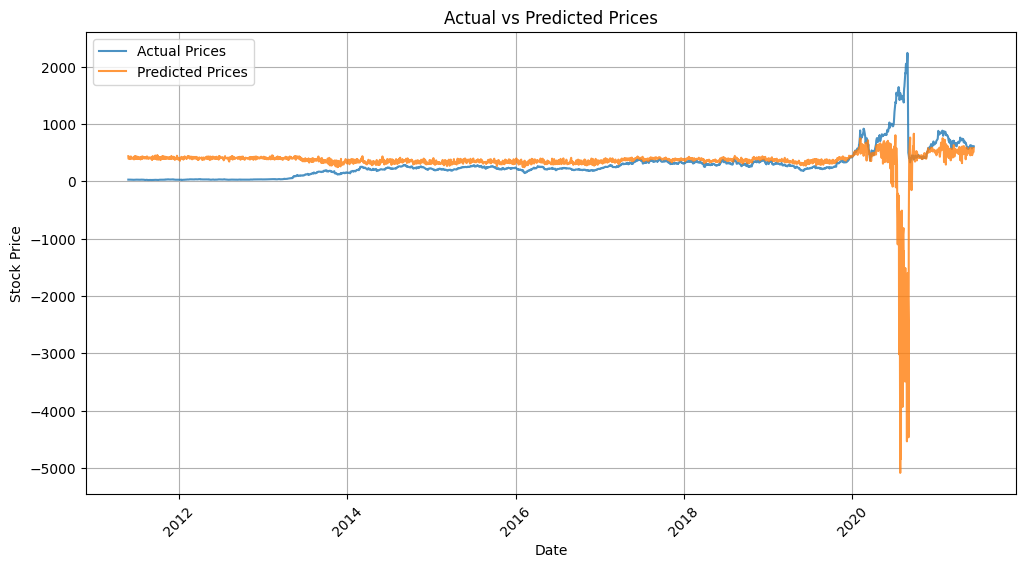

In [ ]:
plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)

## Fifth Model

fifth_gen_model_01

Best model so far - tst_model = load_model(base_path+'simple_lstm_model_epoch_7_1_02.keras')

In [67]:
fifth_model = load_model('./drive/MyDrive/DL_Pickles_3simple_lstm_model_epoch_6_3_20.keras')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
predicted


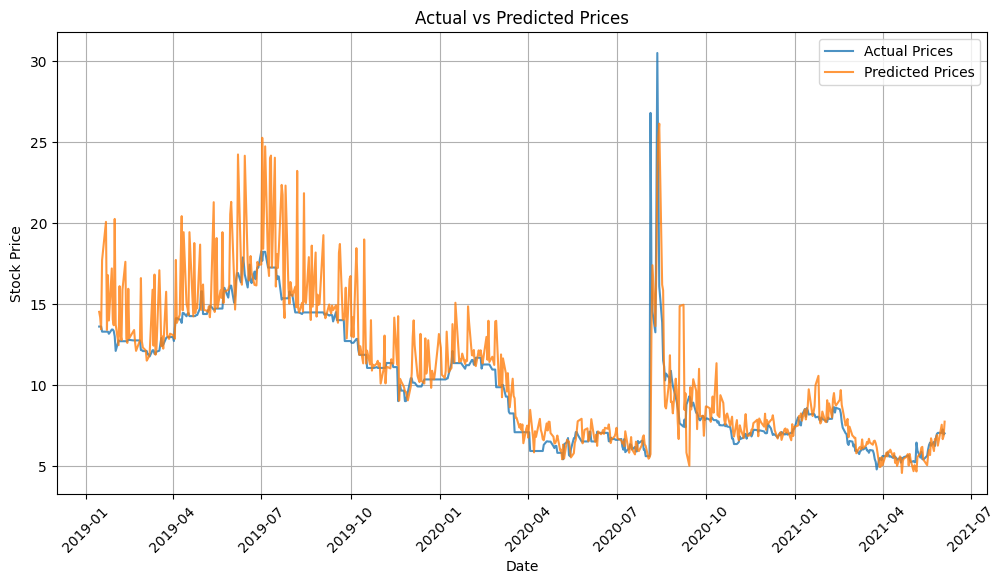

In [92]:
dates, y_sequence_rescaled, y_pred_rescaled = get_sequences_and_predict("BFRA", stock_data_tidy, numerical_columns, sequence_length, fourth_model)
plot_actual_vs_predicted(dates, y_sequence_rescaled, y_pred_rescaled)

## 5. Conclusion

Think of a conclusion, the models are not performing as expected, but maybe I can fix it?

The model seems to be overfitting the data or maybe failing to generalize it properly. Let's try making a simpler model, to see the bevaiour.

We will decrease the number of LSTM units and increate the dropout (this is after the first-second gen?)

## Bibliography

https://drlee.io/advanced-stock-pattern-prediction-using-lstm-with-the-attention-mechanism-in-tensorflow-a-step-by-143a2e8b0e95

https://developer.nvidia.com/discover/lstm#:~:text=A%20Long%20short%2Dterm%20memory,cycles%20through%20the%20feedback%20loops.

https://www.mdpi.com/2227-7072/11/3/94